### EV Adoption Forecasting
As electric vehicle (EV) adoption surges, urban planners need to anticipate infrastructure needs—especially charging stations. Inadequate planning can lead to bottlenecks, impacting user satisfaction and hindering sustainability goals.

**Problem Statement:** Using the electric vehicle dataset (which includes information on EV populations, vehicle types, and possibly historical charging usage), create a model to forecast future EV adoption. For example, predict the number of electric vehicles in upcoming years based on the trends in the data.

**Goal:** Build a regression model that forecasts future EV adoption demand based on historical trends in EV growth, types of vehicles, and regional data.

**Dataset:** This dataset shows the number of vehicles that were registered by Washington State Department of Licensing (DOL) each month. The data is separated by county for passenger vehicles and trucks.

- Date: Counts of registered vehicles are taken on this day (the end of this month). - 2017-01-31
2024-02-29
- County: This is the geographic region of a state that a vehicle's owner is listed to reside within. Vehicles registered in Washington
- State: This is the geographic region of the country associated with the record. These addresses may be located in other
- Vehicle Primary Use: This describes the primary intended use of the vehicle.(Passenger-83%, Truck-17%)
- Battery Electric Vehicles (BEVs): The count of vehicles that are known to be propelled solely by an energy derived from an onboard electric battery.
- Plug-In Hybrid Electric Vehicles (PHEVs): The count of vehicles that are known to be propelled from energy partially sourced from an onboard electric battery
- Electric Vehicle (EV) Total: The sum of Battery Electric Vehicles (BEVs) and Plug-in Hybrid Electric Vehicles (PHEVs).
- Non-Electric Vehicle Total: The count of vehicles that are not electric vehicles.
- Total Vehicles: All powered vehicles registered in the county. This includes electric vehicles.
- Percent Electric Vehicles: Comparison of electric vehicles versus their non-electric counterparts.

**Dataset Link:** https://www.kaggle.com/datasets/sahirmaharajj/electric-vehicle-population-size-2024/data

### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### Importing the Dataset

In [2]:
# Load Dataset
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")

### Data Exploration and Understanding

In [3]:
df.head()  # Display the First 5 Rows of the Dataset

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [6]:
df.shape  # Number of Rows and Columns

(20819, 10)

In [7]:
df.info()   # Summary of Data Structure and Memory Usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [8]:
df.isnull().sum()    # Count of Null Values in Each Column

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

### Identifying Outlier Values in Dataset Features

In [4]:
# Calculate Quartiles Q1 and Q3
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Establish Outlier Boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


### Data Preparation

Initial Data Cleaning

In [5]:
# Convert the "Date" column to datetime format for accurate time-based analysis
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Filter out records with invalid or missing date values
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


Cap Outliers Using IQR Boundaries

In [13]:
# Apply outlier capping to mitigate skewness without removing data points.
df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


Convert Count Data from Text to Numbers

In [7]:
# List of columns where values must be numeric
numeric_columns = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

# Convert each column to numeric type 
for column in numeric_columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Summary of important values in number columns
df[numeric_columns].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20119.000000,13983.000000,13979.000000,20819.000000
mean,25.855176,21.790942,31.623093,132.845312,134.463767,4.139216
std,102.004224,92.309729,115.742017,174.033916,174.448753,11.055350
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.390000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,3.000000,167.000000,169.000000,2.995000
max,999.000000,999.000000,999.000000,999.000000,998.000000,100.000000


Finding Counties with the Highest Number of Electric Vehicles

In [8]:
# Combine data by each County and sum up the total electric vehicles in each
ev_by_county = df.groupby('County')['Electric Vehicle (EV) Total'].sum()

# Arrange counties to find which have the highest and lowest number of electric vehicles
top_counties = ev_by_county.sort_values(ascending=False).head(3)
bottom_counties = ev_by_county.sort_values().head(3)

# Display the results
print("\nTop 3 Counties with the Highest Number of EV:")
print(top_counties)

print("\nBottom 3 Counties with the Lowest Number of EV:")
print(bottom_counties)


Top 3 Counties with the Highest Number of EV:
County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties with the Lowest Number of EV:
County
Brown         1.0
Hood River    1.0
Union         1.0
Name: Electric Vehicle (EV) Total, dtype: float64


Total Number of Vehicles by Category

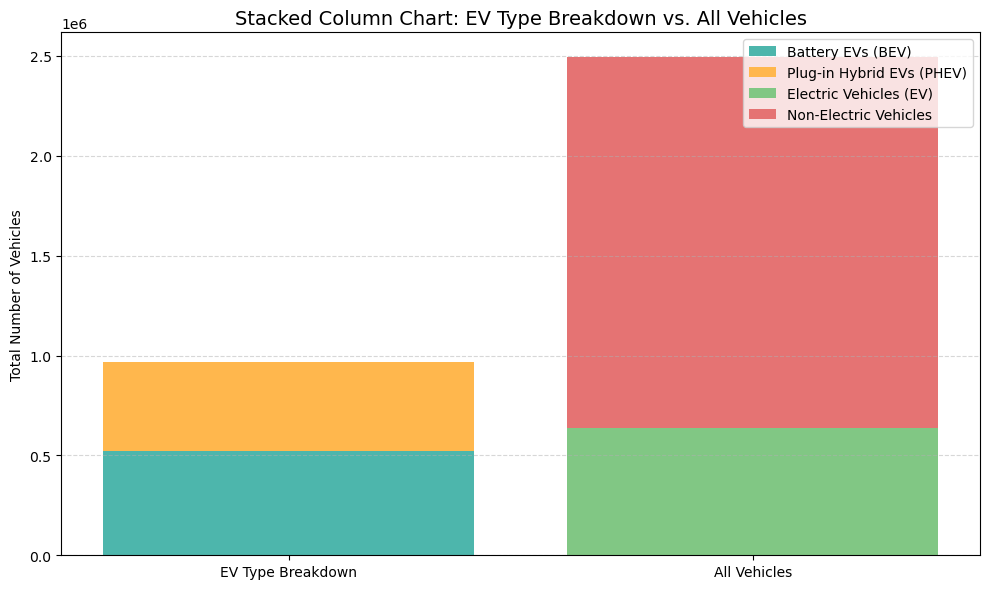

In [10]:
# Calculate Totals for Each Vehicle Type Category 

# Summing the total count for each vehicle category
total_bevs = df['Battery Electric Vehicles (BEVs)'].sum()
total_phevs = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
total_evs = df['Electric Vehicle (EV) Total'].sum()
total_non_evs = df['Non-Electric Vehicle Total'].sum()
total_vehicles = df['Total Vehicles'].sum()

# Plotting a Stacked Column Chart 

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot Breakdown of Electric Vehicle Types (BEV + PHEV) ---
ax.bar('EV Type Breakdown', total_bevs, label='Battery EVs (BEV)', color='#4DB6AC')  # Teal
ax.bar('EV Type Breakdown', total_phevs, bottom=total_bevs, label='Plug-in Hybrid EVs (PHEV)', color='#FFB74D')  # Orange

# Plot Overall Vehicle Composition (EV + Non-EV) ---
ax.bar('All Vehicles', total_evs, label='Electric Vehicles (EV)', color='#81C784')  # Green
ax.bar('All Vehicles', total_non_evs, bottom=total_evs, label='Non-Electric Vehicles', color='#E57373')  # Red

# Add Labels and Styling 
ax.set_ylabel('Total Number of Vehicles')
ax.set_title('Stacked Column Chart: EV Type Breakdown vs. All Vehicles', fontsize=14)
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Display the Chart 
plt.show()

### Feature engineering:

In [11]:
# Get the year, month, and day from the date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce') 
df = df[df['Date'].notnull()]
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['year'] * 12 + df['month']

In [12]:
# Convert county names into numeric codes for easier analysis
label_encoder = LabelEncoder()
df['county_encoded'] = label_encoder.fit_transform(df['County'])

In [13]:
# Order records to enable lag calculation
df = df.sort_values(['County', 'Date'])

Sorting by ['County', 'Date'] is essential before using groupby().shift() to ensure accurate lag feature creation.

Let's creates lag features:
ev_total_lag1, ev_total_lag2, ev_total_lag3

Each one represents the EV total in previous months, specifically:

**Feature	Meaning**
- ev_total_lagX:	How many EVs were registered X months ago
- ev_total_roll_mean_3:	Smoother average of EV total over the past 3 months
- ev_total_pct_change_1:	Monthly growth rate (e.g., from 100 → 120 = +20%)
- ev_total_pct_change_3:	3-month growth trend (captures momentum)

It does this for each county independently using groupby('County').

In [14]:
# Create a time-based index for each county
df['months_since_start'] = df.groupby('County').cumcount()

# Create Lag Features: EV Count 1, 2, and 3 Months Ago 
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# Create 3-Month Rolling Average 
df['ev_total_roll_mean_3'] = (
    df.groupby('County')['Electric Vehicle (EV) Total']
      .transform(lambda x: x.shift(1).rolling(3).mean())
)

# Calculate Percent Change in EV Count (1-month and 3-month)
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# Clean Up
for col in ['ev_total_pct_change_1', 'ev_total_pct_change_3']:
    df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(0)

In time-series forecasting, past values often influence future ones. Lag features allow your model to learn trends like: "If EV count increased in the last 3 months, it’s likely to keep increasing."

These lagged values act as predictive memory of the system.

- ev_growth_slope - Trend in cumulative EV count over 6 months for early-stage EV adoption.

In [15]:
# Total electric vehicles accumulated in each county over time
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# Compute the 6-month moving slope to show growth trends in cumulative data
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(window=6).apply(
        lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan
    )
)

We can also introduce the acceleration, If **slope = rate of growth**, acceleration = rate of change of slope. It helps to understand whether the growth is speeding up or slowing down — very useful in S-curve adoption(describes how a new product or technology's adoption progresses over time). Since Our data is small for a county we will not introduce it.

In [16]:
# Remove initial rows that don’t have previous data to compare
df = df.dropna().reset_index(drop=True)

In [17]:
df.to_csv('preprocessed_ev_data.csv', index=False)
df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,county_encoded,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,0,5.0,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,0,6.0,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,0,7.0,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,0,8.0,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,0,9.0,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000


In [18]:
# Define features and target
features = [
    'months_since_start',
    'county_encoded',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

X.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5.0,0,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6.0,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7.0,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8.0,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9.0,0,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [19]:
X.shape

(12492, 9)

In [20]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [21]:
y_test.head()

11242    2.0
11243    1.0
11244    2.0
11245    2.0
11246    1.0
Name: Electric Vehicle (EV) Total, dtype: float64

### Model Selection

Type of Problem:
Regression Problem - Predicting continuous values like 'Electric Vehicle (EV) Total'

Algorithms Considered: Random Forest Regressor

Chosen Model:
Random Forest for its robustness and ability to model non-linear relationships.

Model Training, Tuning and Optimization
Why Tuning?
- Improves performance by finding the best model parameters.

Techniques:
- RandomizedSearchCV for hyperparameter tuning.
- Cross-validation to avoid overfitting.

In [23]:
# Define the Hyperparameter Search Space 
param_dist = {
    'n_estimators': [100, 150, 200, 250],          
    'max_depth': [None, 5, 10, 15],                
    'min_samples_split': [2, 4, 6, 8],             
    'min_samples_leaf': [1, 2, 3],                 
    'max_features': ['sqrt', 'log2', None]         
}

# Initialize the Base Random Forest Model 
rf = RandomForestRegressor(random_state=42)

# Setup Randomized Search for Hyperparameter Tuning 
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,                
    scoring='r2',               
    cv=3,                       
    n_jobs=-1,                 
    verbose=1,                  
    random_state=42
)

# Fit the Model to Training Data 
print(" Performing hyperparameter tuning with RandomizedSearchCV")
random_search.fit(X_train, y_train)

# Retrieve the Best Model 
model = random_search.best_estimator_
print("\n Best Parameters Found:")
print(random_search.best_params_)

 Performing hyperparameter tuning with RandomizedSearchCV
Fitting 3 folds for each of 30 candidates, totalling 90 fits

 Best Parameters Found:
{'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 15}


In [24]:
# Make predictions using the model and check how accurate they are
y_pred = model.predict(X_test)

In [33]:
X_test.head()

,months_since_start,county_encoded,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
11242,24.0,270,1.0,1.0,1.0,1.000000,1.0,1.0,1.142857
11243,25.0,270,2.0,1.0,1.0,1.333333,-0.5,0.0,1.228571
11244,26.0,270,1.0,2.0,1.0,1.333333,1.0,1.0,1.400000
11245,27.0,270,2.0,1.0,2.0,1.666667,0.0,0.0,1.600000
11246,28.0,270,2.0,2.0,1.0,1.666667,-0.5,0.0,1.628571


### Model Evaluation

Evaluation Metrics:
- Mean Squared Error (MSE) – Penalizes larger errors.
- R² Score – Measures goodness of fit.

In [25]:
# Create a DataFrame with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual EV Count': y_test.values,                  
    'Predicted EV Count': y_pred                       
})

# Round predicted values for better readability
comparison_df['Predicted EV Count'] = comparison_df['Predicted EV Count'].round(2)

# Optional: Reset index for cleaner display
comparison_df.reset_index(drop=True, inplace=True)

# Display the first 10 rows for a quick look
print("Actual vs Predicted Electric Vehicle Counts (Sample)")
comparison_df.head(10)

Actual vs Predicted Electric Vehicle Counts (Sample)


,Actual EV Count,Predicted EV Count
0,2.0,2.00
1,1.0,1.00
2,2.0,2.00
3,2.0,1.97
4,1.0,1.01
5,2.0,2.00
6,1.0,1.00
7,1.0,1.00
8,2.0,2.00
9,2.0,2.00


**Actual vs Predicted EV Count**

Model Evaluation Metrics
MAE (Mean Absolute Error): 0.01
RMSE (Root Mean Squared Error): 0.05
R² Score: 1.00


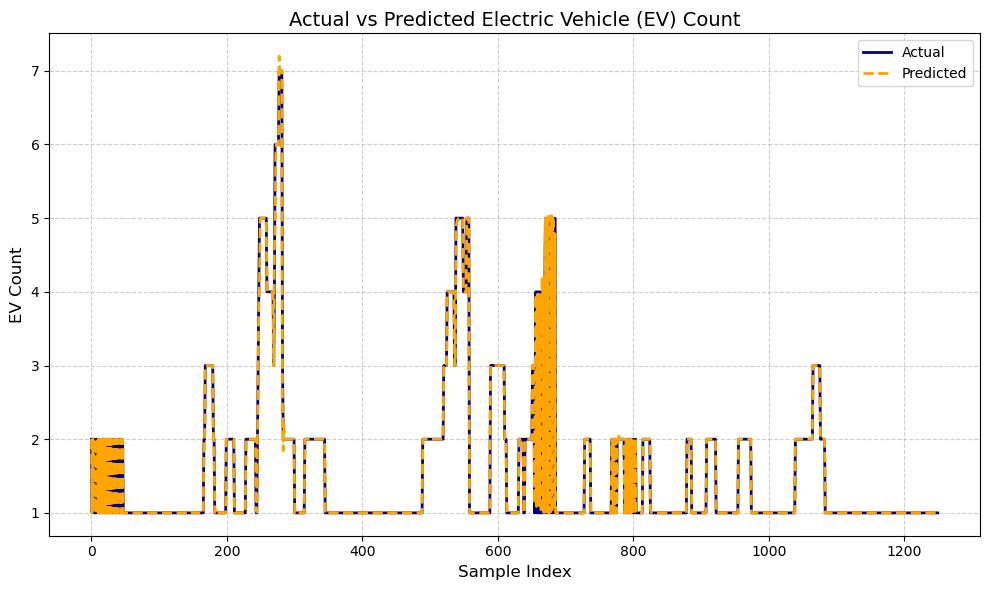

In [26]:
# Function to evaluate model performance
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2Score = r2_score(y_true, y_pred)

    print("Model Evaluation Metrics")
    print(f"MAE (Mean Absolute Error): {mae:.2f}")
    print(f"RMSE (Root Mean Squared Error): {rmse:.2f}")
    print(f"R² Score: {r2Score:.2f}")

# Evaluate predictions
evaluate(y_test, y_pred)

# Plotting Actual vs Predicted EV Counts
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual', color='navy', linewidth=2)
plt.plot(y_pred, label='Predicted', color='orange', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Electric Vehicle (EV) Count", fontsize=14)
plt.xlabel("Sample Index", fontsize=12)
plt.ylabel("EV Count", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

**Get Feature Importance**

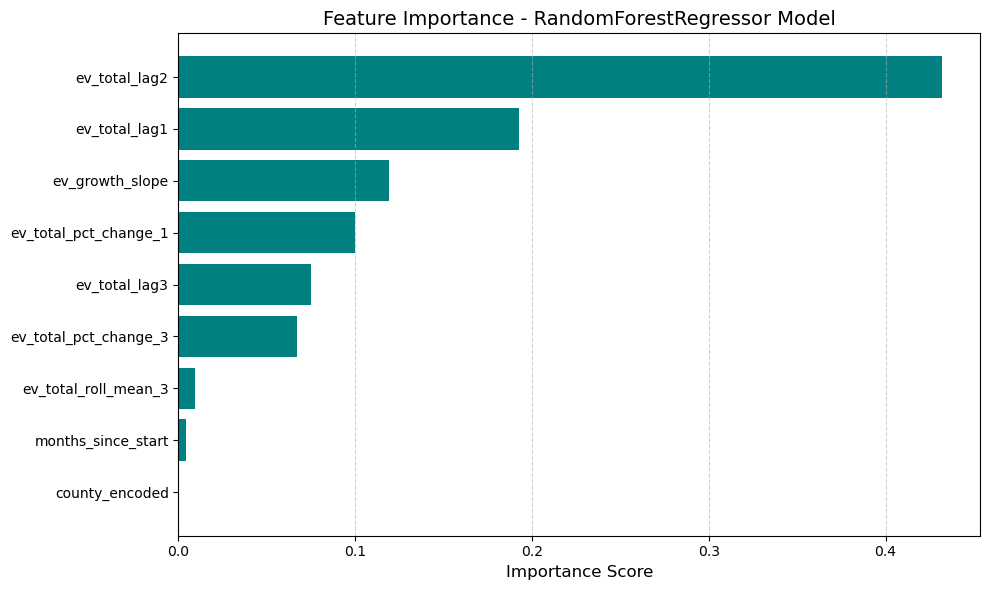

In [27]:
# This attribute gives the importance score of each feature used in the model
importances = model.feature_importances_

# Pair feature names with their importance scores and sort
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='teal')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Feature Importance - RandomForestRegressor Model', fontsize=14)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The bar chart visualizes the relative importance of various input features in predicting EV adoption using a Random Forest Regressor. Each bar represents the contribution of a specific feature to the model's predictive power. Key insights include:

Top Features:

- ev_total_lag2 is the most influential feature, indicating that the EV count from two months prior is the strongest predictor of future EV adoption.

- ev_total_lag1 and ev_growth_slope also have high importance, reflecting that recent trends and growth trajectories significantly affect predictions.

Moderately Important:

- ev_total_pct_change_1 (recent percentage change) and ev_total_lag3 (three-month lag) play supporting roles in forecasting.

- ev_total_pct_change_3 has a smaller, yet noticeable impact.

Least Important:

- months_since_start, county_encoded, and ev_total_roll_mean_3 contribute very little to the model. This suggests that time index and county encoding have minimal standalone predictive value, and short rolling averages are less informative compared to lag features.

Overall, the chart highlights that lag-based features and recent growth patterns are the most effective predictors of EV adoption in this model setup.

A good growth rate, especially in technology, is subjective and depends on the specific context, but generally, anything above 10% per year is considered a strong growth rate. In the electric vehicle (EV) market, as per Fortune Business Insights suggests a 13.8% CAGR between 2024 and 2032.

### Predicting EV Adoption Over the Next 3 Years

**Forecasting total eletric vehicles for a specific county (e.g., Clark)**

In [28]:
# Define the features and Target related to counties
featuresX = ['County', 'county_encoded']
countyX = df[featuresX]

# Print the list of unique counties
unique_counties = df['County'].dropna().unique()
print("List of Unique Counties:\n")
for i, county in enumerate(unique_counties, start=1):
    print(f"{i}. {county}")

# Print the total number of unique counties
print(f"\nTotal Number of Unique Counties: {df['County'].nunique()}")

List of Unique Counties:

1. Ada
2. Adams
3. Alameda
4. Albemarle
5. Alexandria
6. Allegheny
7. Allen
8. Anchorage
9. Anne Arundel
10. Arapahoe
11. Arlington
12. Atlantic
13. Autauga
14. Baltimore
15. Bartow
16. Beaufort
17. Bell
18. Bergen
19. Berkeley
20. Berkshire
21. Bexar
22. Boone
23. Boulder
24. Bradley
25. Brevard
26. Broward
27. Bryan
28. Bucks
29. Burlington
30. Caddo
31. Calvert
32. Camden
33. Canyon
34. Carroll
35. Carson City
36. Cascade
37. Champaign
38. Charles
39. Charleston
40. Charlottesville
41. Chesapeake
42. Clackamas
43. Clay
44. Clinton
45. Cobb
46. Cochise
47. Collier
48. Collin
49. Columbia
50. Contra Costa
51. Cook
52. Coryell
53. Cumberland
54. Currituck
55. Dakota
56. Dale
57. Dallas
58. Dane
59. Danville
60. DeKalb
61. Denton
62. Denver
63. Deschutes
64. District of Columbia
65. Dorchester
66. Douglas
67. DuPage
68. Duval
69. Eagle
70. Eau Claire
71. El Dorado
72. El Paso
73. Escambia
74. Essex
75. Fairbanks North Star
76. Fairfax
77. Flathead
78. Fort Bend

County 'Kings' encoded as 130.


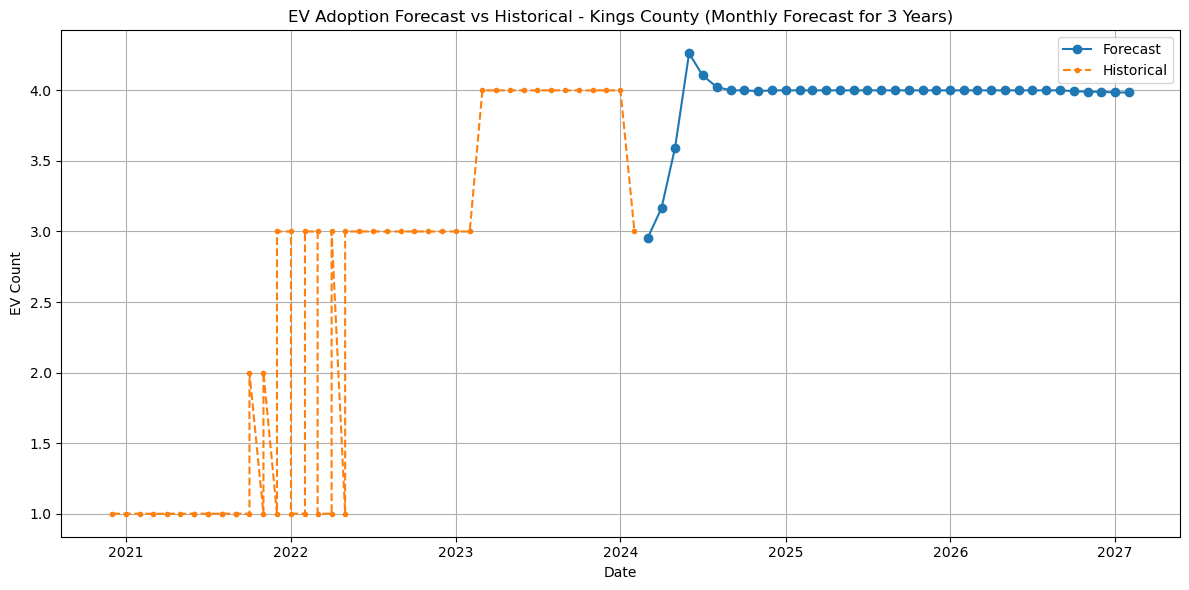

In [29]:
# Choose a County name
selected_county = "Kings"

# Encode the selected county name to match model input format
try:
    encoded_county = label_encoder.transform([selected_county])[0]
    print(f"County '{selected_county}' encoded as {encoded_county}.")
except ValueError:
    print(f"Error: County '{selected_county}' not found in dataset.")
    exit()

# Filter Historical Data for the Selected County
county_data = df[df['county_encoded'] == encoded_county].sort_values("numeric_date")

if county_data.empty:
    print(f"No data available for {selected_county}.")
    exit()

# Prepare Past 6 Months EV Data
ev_history = list(county_data['Electric Vehicle (EV) Total'].values[-6:])
cumulative_ev = list(np.cumsum(ev_history))
months = county_data['months_since_start'].max()

# Convert existing data to plot-friendly format
historical_df = county_data[['year', 'month', 'numeric_date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
historical_df['Source'] = 'Historical'
historical_df['Date'] = pd.to_datetime(historical_df[['year', 'month']].assign(day=1))

# Forecast EV Adoption for the Next 3 Years (36 Months)
future_predictions = []
latest_data_point = county_data.iloc[-1].copy()

for i in range(36):  # Forecasting next 36 months
    # Calculate next month
    next_date = pd.to_datetime(latest_data_point['year'] * 100 + latest_data_point['month'], format='%Y%m') + pd.DateOffset(months=1)
    year, month = next_date.year, next_date.month
    months += 1

    # Extract lag values and compute features
    lag1, lag2, lag3 = ev_history[-1], ev_history[-2], ev_history[-3]
    rolling_avg = np.mean([lag1, lag2, lag3])
    pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
    pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0
    slope = np.polyfit(range(6), cumulative_ev[-6:], 1)[0] if len(cumulative_ev) >= 6 else 0

    # Prepare features for prediction
    new_input = pd.DataFrame([{
        'months_since_start': months,
        'county_encoded': encoded_county,
        'ev_total_lag1': lag1,
        'ev_total_lag2': lag2,
        'ev_total_lag3': lag3,
        'ev_total_roll_mean_3': rolling_avg,
        'ev_total_pct_change_1': pct_change_1,
        'ev_total_pct_change_3': pct_change_3,
        'ev_growth_slope': slope
    }])[features]

    # Predict EV count for the future month
    predicted_ev = model.predict(new_input)[0]

    # Update history for next loop
    ev_history.append(predicted_ev)
    if len(ev_history) > 6:
        ev_history.pop(0)

    cumulative_ev.append(cumulative_ev[-1] + predicted_ev)
    if len(cumulative_ev) > 6:
        cumulative_ev.pop(0)

    # Store prediction result
    future_predictions.append({
        'Date': next_date,
        'Electric Vehicle (EV) Total': predicted_ev,
        'months_since_start': months,
        'Source': 'Forecast'
    })

    # Update for next loop
    latest_data_point['year'], latest_data_point['month'] = year, month

# Step 5: Combine Historical and Forecasted Data
forecast_df = pd.DataFrame(future_predictions)
combined_df = pd.concat([historical_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start', 'Source']], forecast_df], ignore_index=True)

# Step 6: Plot the Results
plt.figure(figsize=(12, 6))
for source, group in combined_df.groupby('Source'):
    plt.plot(group['Date'], group['Electric Vehicle (EV) Total'], label=source,
             marker='o' if source == 'Forecast' else '.', linestyle='-' if source == 'Forecast' else '--')

plt.title(f"EV Adoption Forecast vs Historical - {selected_county} County (Monthly Forecast for 3 Years)")
plt.xlabel("Date")
plt.ylabel("EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

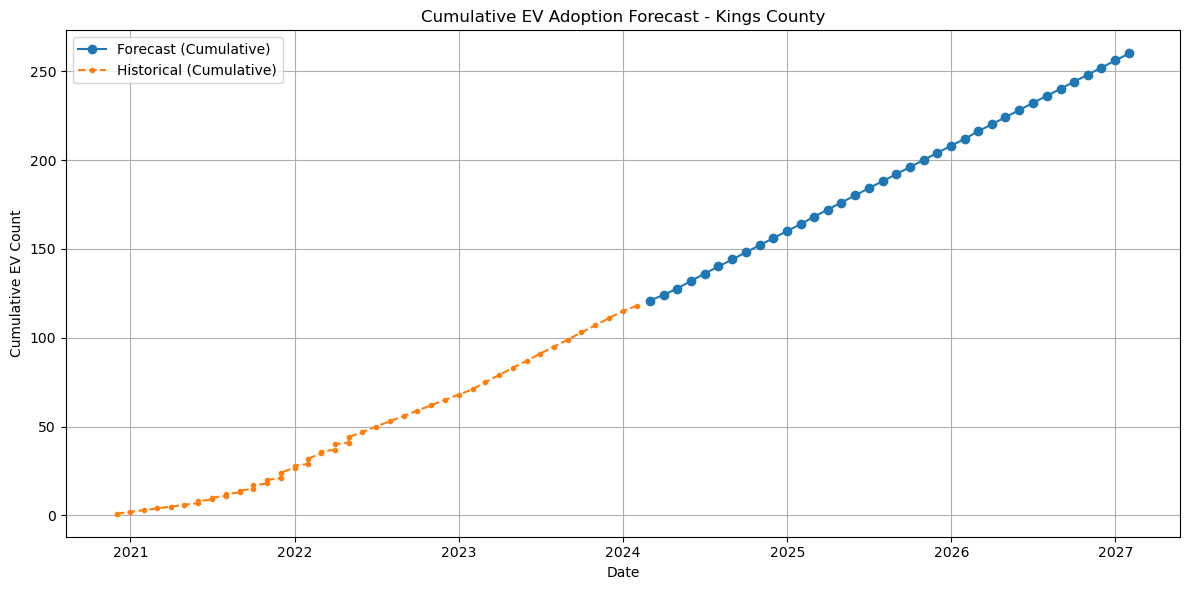

In [45]:
# Using data to estimate electric vehicle growth for the next 3 years
combined_df = combined_df.sort_values("Date")

combined_df['Cumulative EVs'] = combined_df['Electric Vehicle (EV) Total'].cumsum()

plt.figure(figsize=(12, 6))
for src, group in combined_df.groupby('Source'):
    plt.plot(group['Date'], group['Cumulative EVs'],
             label=f'{src} (Cumulative)',
             linestyle='-' if src == 'Forecast' else '--',
             marker='o' if src == 'Forecast' else '.')

plt.title(f"Cumulative EV Adoption Forecast - {selected_county} County")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

From 2020 to the end of 2023, Kings County experienced a steady and accelerating growth in EV adoption. The cumulative count increased consistently, indicating a positive trend in EV acceptance among residents.

The forecast projects a continued linear growth in EV adoption from 2024 through 2027. The projection suggests no significant slowdown, with the cumulative EV count potentially doubling within this period.

This anticipated growth may require expanded EV infrastructure, including charging stations, grid upgrades, and maintenance services to support the rising demand.

**Forecasting for Top-5 Counties**

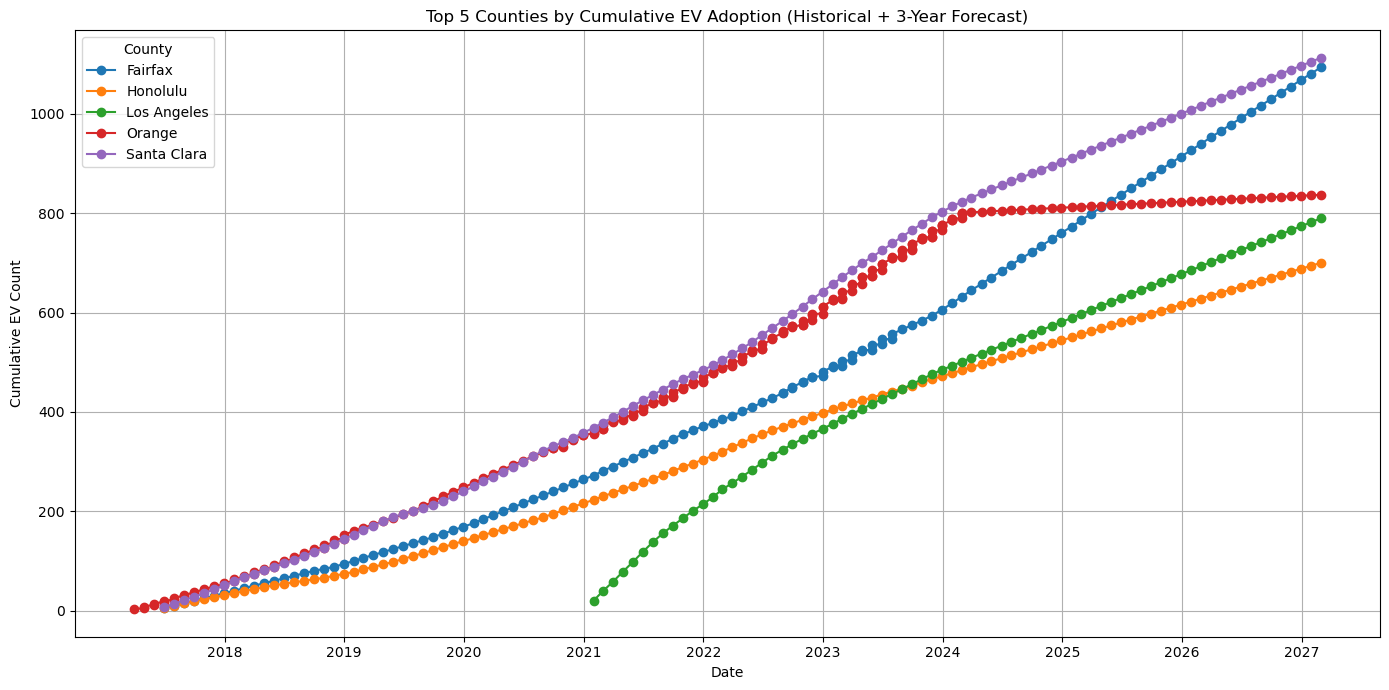

In [34]:
forecast_horizon = 36  # 3 years = 36 months

all_combined = []
unique_counties = df['County'].dropna().unique()

for county in unique_counties:
    try:
        county_code = label_encoder.transform([county])[0]
    except ValueError:
        continue

    county_df = df[df['county_encoded'] == county_code].sort_values("numeric_date")
    if county_df.empty or county_df.shape[0] < 6:
        continue

    # Extract initial months_since_start
    months_since_start = county_df['months_since_start'].max()

    historical = county_df[['Date', 'Electric Vehicle (EV) Total', 'months_since_start']].copy()
    historical['Source'] = 'Historical'
    historical['County'] = county

    historical_ev = list(county_df['Electric Vehicle (EV) Total'].values[-6:])
    cumulative_ev = list(np.cumsum(historical_ev))
    slope_history = []

    future_rows = []

    for _ in range(forecast_horizon):
        months_since_start += 1

        lag1, lag2, lag3 = historical_ev[-1], historical_ev[-2], historical_ev[-3]
        roll_mean = np.mean([lag1, lag2, lag3])
        pct_change_1 = (lag1 - lag2) / lag2 if lag2 != 0 else 0
        pct_change_3 = (lag1 - lag3) / lag3 if lag3 != 0 else 0

        recent_cumulative = cumulative_ev[-6:]
        ev_growth_slope = np.polyfit(range(len(recent_cumulative)), recent_cumulative, 1)[0] if len(recent_cumulative) == 6 else 0

        # Optional: track slope history for acceleration (not used here)
        slope_history.append(ev_growth_slope)
        if len(slope_history) > 2:
            slope_history.pop(0)

        new_row = {
            'months_since_start': months_since_start,
            'county_encoded': county_code,
            'ev_total_lag1': lag1,
            'ev_total_lag2': lag2,
            'ev_total_lag3': lag3,
            'ev_total_roll_mean_3': roll_mean,
            'ev_total_pct_change_1': pct_change_1,
            'ev_total_pct_change_3': pct_change_3,
            'ev_growth_slope': ev_growth_slope
        }

        # Predict
        X_new = pd.DataFrame([new_row])[features]
        pred = model.predict(X_new)[0]
        new_row['Electric Vehicle (EV) Total'] = pred

        # Store for plotting
        forecast_date = historical['Date'].max() + pd.DateOffset(months=len(future_rows) + 1)
        future_rows.append({
            'Date': forecast_date,
            'Electric Vehicle (EV) Total': pred,
            'months_since_start': months_since_start,
            'County': county,
            'Source': 'Forecast'
        })

        # Update EV history
        historical_ev.append(pred)
        if len(historical_ev) > 6:
            historical_ev.pop(0)

        cumulative_ev.append(cumulative_ev[-1] + pred)
        if len(cumulative_ev) > 6:
            cumulative_ev.pop(0)

    forecast_df = pd.DataFrame(future_rows)
    combined = pd.concat([historical, forecast_df], ignore_index=True)
    combined = combined.sort_values("Date")
    combined['Cumulative EVs'] = combined['Electric Vehicle (EV) Total'].cumsum()

    all_combined.append(combined)

# Combine all counties
full_df = pd.concat(all_combined)

# Get final cumulative EV count per county
final_totals = full_df.groupby('County')['Cumulative EVs'].max().sort_values(ascending=False)
top_5_counties = final_totals.head(5).index.tolist()

# Filter top 5 counties
top_5_df = full_df[full_df['County'].isin(top_5_counties)]

# Plot
plt.figure(figsize=(14, 7))
for county, group in top_5_df.groupby('County'):
    plt.plot(group['Date'], group['Cumulative EVs'], label=county, marker='o')

# Format x-axis to show one tick per year
plt.title("Top 5 Counties by Cumulative EV Adoption (Historical + 3-Year Forecast)")
plt.xlabel("Date")
plt.ylabel("Cumulative EV Count")
plt.grid(True)
plt.legend(title="County")
plt.xticks(
    ticks=pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS'),
    labels=[str(d.year) for d in pd.date_range(start=top_5_df['Date'].min(), end=top_5_df['Date'].max(), freq='YS')],
    rotation=0
)
plt.tight_layout()
plt.show()

The graph compares the historical and projected cumulative electric vehicle (EV) adoption trends for the top 5 U.S. counties—Santa Clara, Fairfax, Orange, Honolulu, and Los Angeles—from around 2017 to 2027.

**Key Observations:**
- Santa Clara County (Purple Line):

  Leads in EV adoption overall.

  Demonstrates a strong and steady growth trajectory, continuing into the forecast period.

- Fairfax County (Blue Line):

  Shows consistent acceleration, overtaking others around 2025.

- Orange County (Red Line):

  Had a rapid growth phase, but its forecast shows flattening after 2024.

- Honolulu County (Orange Line):

  Exhibits moderate but stable growth, suggesting steady but slower adoption.

  May reflect geographical constraints or limited incentives.

- Los Angeles County (Green Line):

  Adoption started later but shows strong upward momentum.

  The forecast predicts continued growth but at a slower rate than Santa Clara or Fairfax.

Santa Clara and Fairfax are expected to dominate EV adoption through 2027, with both maintaining strong momentum. Meanwhile, Orange County may face a plateau, and Honolulu and Los Angeles will likely continue on steady but less aggressive growth trajectories. These trends can inform regional planning, charging infrastructure deployment, and policy decisions tailored to each county's adoption pace.

### Final Model Testing and Save the Model

In [35]:
import joblib

# Save the trained model to file
joblib.dump(model, 'forecasting_ev_model.pkl')
print("Model saved to 'forecasting_ev_model.pkl'")

Model saved to 'forecasting_ev_model.pkl'


In [36]:
# Load model from file
loaded_model = joblib.load('forecasting_ev_model.pkl')
print("Model loaded successfully.")

Model loaded successfully.


In [38]:
# Predicting on a single sample from the test set
sample = X_test.iloc[[0]] 
true_value = y_test.iloc[0]
predicted_value = loaded_model.predict(sample)[0]

print("\n Model Prediction Test (Single Sample):")
print(f" County: {df.iloc[sample.index[0]]['County']}")
print(f" Actual EV Count     : {true_value:.2f}")
print(f" Predicted EV Count  : {predicted_value:.2f}")


 Model Prediction Test (Single Sample):
 County: Suffolk
 Actual EV Count     : 2.00
 Predicted EV Count  : 2.00
